In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os
import joblib


In [4]:
# joblib.dump(data, 'data_with_features.joblib')
data = joblib.load('data.joblib')
data

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features,label
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126...",-1.303196
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10...",-0.832509
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096...",-1.278754
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0....",2.124939
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0....",1.408935
...,...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-2.980003
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737...",-0.826075


In [5]:
# adding 1e-9 to prevent error when doing logarithm
# ??????
data['label'] = -np.log10(data['Raw Kd'] + 1e-9)

In [6]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [7]:
# Separate the dataset by unique proteins and drugs
unique_proteins = data['Sequence'].unique()
unique_mols = data['Smiles'].unique()
# Set the seed for reproducibility
torch.manual_seed(42)
# Function to perform a cold split
def cold_split(unique_items, test_size=0.2, val_size=0.1):
    train_items, test_items = train_test_split(unique_items, test_size=test_size, random_state=42)
    train_items, val_items = train_test_split(train_items, test_size=val_size / (1 - test_size), random_state=42)
    return train_items, val_items, test_items
# Cold split by proteins
train_proteins, val_proteins, test_proteins = cold_split(unique_proteins)
train_cold_protein = data[data['Sequence'].isin(train_proteins)]
val_cold_protein = data[data['Sequence'].isin(val_proteins)]
test_cold_protein = data[data['Sequence'].isin(test_proteins)]
# Cold split by molecules
train_mols, val_mols, test_mols = cold_split(unique_mols)
train_cold_mols = data[data['Smiles'].isin(train_mols)]
val_cold_mols = data[data['Smiles'].isin(val_mols)]
test_cold_mols = data[data['Smiles'].isin(test_mols)]

In [8]:
# cold protein
'''
train_dataset = MPI_Dataset(train_cold_protein)
val_dataset = MPI_Dataset(val_cold_protein)
test_dataset = MPI_Dataset(test_cold_protein)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
'''


# cold mols


train_dataset = MPI_Dataset(train_cold_mols)
val_dataset = MPI_Dataset(val_cold_mols)
test_dataset = MPI_Dataset(test_cold_mols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
'''
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
'''

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define CNN Model for Regression
class CNNRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, out_dim=1):
        super(CNNRegressor, self).__init__()

        self.mol_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.protein_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        with torch.no_grad():
            dummy_mol = torch.zeros(1, 1, mol_input_dim)
            dummy_protein = torch.zeros(1, 1, protein_input_dim)
    
            mol_flatten_len = self.mol_conv(dummy_mol).view(1, -1).size(1)
            protein_flatten_len = self.protein_conv(dummy_protein).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(mol_flatten_len + protein_flatten_len, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, out_dim)
        )

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_input = mol_input.unsqueeze(1)
        protein_input = protein_input.unsqueeze(1)

        mol_out = self.mol_conv(mol_input)
        protein_out = self.protein_conv(protein_input)

        # Flatten
        mol_out = mol_out.view(mol_out.size(0), -1)
        protein_out = protein_out.view(protein_out.size(0), -1)

        combined = torch.cat([mol_out, protein_out], dim=1)
        output = self.fc(combined).squeeze()
        return output


In [10]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = CNNRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [ ]:


# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")


Training Epoch 1:   0%|          | 0/373 [00:00<?, ?it/s]

Training Epoch 1: 100%|██████████| 373/373 [00:10<00:00, 36.87it/s]


Epoch 0 - Train Loss: 2.2295, Train MSE: 2.2324, Train MAE: 1.1685


/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_29059/3486802603.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.2268, Validation MSE: 2.2253, Validation MAE: 1.1522


Training Epoch 11: 100%|██████████| 373/373 [00:10<00:00, 37.13it/s]


Epoch 10 - Train Loss: 1.7141, Train MSE: 1.7160, Train MAE: 1.0155
Epoch 10 - Validation Loss: 1.7928, Validation MSE: 1.7936, Validation MAE: 1.0255


Training Epoch 21: 100%|██████████| 373/373 [00:10<00:00, 37.21it/s]


Epoch 20 - Train Loss: 1.5546, Train MSE: 1.5562, Train MAE: 0.9604
Epoch 20 - Validation Loss: 1.6613, Validation MSE: 1.6626, Validation MAE: 0.9810


Training Epoch 31: 100%|██████████| 373/373 [00:09<00:00, 40.52it/s]


Epoch 30 - Train Loss: 1.4643, Train MSE: 1.4663, Train MAE: 0.9304
Epoch 30 - Validation Loss: 1.5936, Validation MSE: 1.5953, Validation MAE: 0.9472


Training Epoch 41: 100%|██████████| 373/373 [00:09<00:00, 39.04it/s]


Epoch 40 - Train Loss: 1.3867, Train MSE: 1.3898, Train MAE: 0.9104
Epoch 40 - Validation Loss: 1.5456, Validation MSE: 1.5479, Validation MAE: 0.9282


Training Epoch 51: 100%|██████████| 373/373 [00:09<00:00, 38.80it/s]


Epoch 50 - Train Loss: 1.2988, Train MSE: 1.3018, Train MAE: 0.8770
Epoch 50 - Validation Loss: 1.5361, Validation MSE: 1.5388, Validation MAE: 0.9441


Training Epoch 61: 100%|██████████| 373/373 [00:09<00:00, 38.88it/s]


Epoch 60 - Train Loss: 1.2398, Train MSE: 1.2382, Train MAE: 0.8492
Epoch 60 - Validation Loss: 1.4589, Validation MSE: 1.4613, Validation MAE: 0.8914


Training Epoch 71: 100%|██████████| 373/373 [00:09<00:00, 38.73it/s]


Epoch 70 - Train Loss: 1.1765, Train MSE: 1.1724, Train MAE: 0.8244
Epoch 70 - Validation Loss: 1.4332, Validation MSE: 1.4362, Validation MAE: 0.8755


Training Epoch 81: 100%|██████████| 373/373 [00:09<00:00, 38.48it/s]


Epoch 80 - Train Loss: 1.1273, Train MSE: 1.1294, Train MAE: 0.8086
Epoch 80 - Validation Loss: 1.3800, Validation MSE: 1.3828, Validation MAE: 0.8728


Training Epoch 91: 100%|██████████| 373/373 [00:09<00:00, 38.60it/s]


Epoch 90 - Train Loss: 1.1046, Train MSE: 1.1008, Train MAE: 0.7998
Epoch 90 - Validation Loss: 1.3662, Validation MSE: 1.3689, Validation MAE: 0.8699


Training Epoch 101: 100%|██████████| 373/373 [00:11<00:00, 32.22it/s]


Epoch 100 - Train Loss: 1.0668, Train MSE: 1.0656, Train MAE: 0.7801
Epoch 100 - Validation Loss: 1.3471, Validation MSE: 1.3498, Validation MAE: 0.8542


Training Epoch 111: 100%|██████████| 373/373 [00:09<00:00, 38.02it/s]


Epoch 110 - Train Loss: 1.0201, Train MSE: 1.0208, Train MAE: 0.7618
Epoch 110 - Validation Loss: 1.3292, Validation MSE: 1.3321, Validation MAE: 0.8493


Training Epoch 121: 100%|██████████| 373/373 [00:10<00:00, 37.26it/s]


Epoch 120 - Train Loss: 0.9959, Train MSE: 0.9967, Train MAE: 0.7534
Epoch 120 - Validation Loss: 1.3217, Validation MSE: 1.3248, Validation MAE: 0.8384


Training Epoch 131: 100%|██████████| 373/373 [00:10<00:00, 37.23it/s]


Epoch 130 - Train Loss: 0.9700, Train MSE: 0.9689, Train MAE: 0.7414
Epoch 130 - Validation Loss: 1.3559, Validation MSE: 1.3587, Validation MAE: 0.8345


Training Epoch 141: 100%|██████████| 373/373 [00:10<00:00, 37.27it/s]


Epoch 140 - Train Loss: 0.9285, Train MSE: 0.9300, Train MAE: 0.7240
Epoch 140 - Validation Loss: 1.3283, Validation MSE: 1.3308, Validation MAE: 0.8611


Training Epoch 151: 100%|██████████| 373/373 [15:10<00:00,  2.44s/it]  


Epoch 150 - Train Loss: 0.9090, Train MSE: 0.9091, Train MAE: 0.7190
Epoch 150 - Validation Loss: 1.2743, Validation MSE: 1.2771, Validation MAE: 0.8112


Training Epoch 161: 100%|██████████| 373/373 [00:10<00:00, 36.10it/s]


Epoch 160 - Train Loss: 0.9143, Train MSE: 0.9043, Train MAE: 0.7150
Epoch 160 - Validation Loss: 1.2701, Validation MSE: 1.2726, Validation MAE: 0.8242


Training Epoch 171: 100%|██████████| 373/373 [00:10<00:00, 36.39it/s]


Epoch 170 - Train Loss: 0.8919, Train MSE: 0.8933, Train MAE: 0.7076
Epoch 170 - Validation Loss: 1.2723, Validation MSE: 1.2746, Validation MAE: 0.8042


Training Epoch 181: 100%|██████████| 373/373 [00:10<00:00, 35.85it/s]


Epoch 180 - Train Loss: 0.8589, Train MSE: 0.8599, Train MAE: 0.6953
Epoch 180 - Validation Loss: 1.2287, Validation MSE: 1.2310, Validation MAE: 0.7944


Training Epoch 191: 100%|██████████| 373/373 [00:10<00:00, 35.06it/s]


Epoch 190 - Train Loss: 0.8554, Train MSE: 0.8517, Train MAE: 0.6871
Epoch 190 - Validation Loss: 1.2406, Validation MSE: 1.2429, Validation MAE: 0.7977


Training Epoch 201: 100%|██████████| 373/373 [00:10<00:00, 36.62it/s]


Epoch 200 - Train Loss: 0.8360, Train MSE: 0.8377, Train MAE: 0.6847
Epoch 200 - Validation Loss: 1.3241, Validation MSE: 1.3265, Validation MAE: 0.8572


Training Epoch 211: 100%|██████████| 373/373 [00:10<00:00, 36.44it/s]


Epoch 210 - Train Loss: 0.8273, Train MSE: 0.8288, Train MAE: 0.6814
Epoch 210 - Validation Loss: 1.2526, Validation MSE: 1.2549, Validation MAE: 0.7936


Training Epoch 221: 100%|██████████| 373/373 [00:10<00:00, 36.26it/s]


Epoch 220 - Train Loss: 0.8115, Train MSE: 0.8116, Train MAE: 0.6712
Epoch 220 - Validation Loss: 1.2311, Validation MSE: 1.2332, Validation MAE: 0.8012


Training Epoch 231: 100%|██████████| 373/373 [00:10<00:00, 36.71it/s]


Epoch 230 - Train Loss: 0.7977, Train MSE: 0.7976, Train MAE: 0.6662
Epoch 230 - Validation Loss: 1.2558, Validation MSE: 1.2580, Validation MAE: 0.7932


Training Epoch 241: 100%|██████████| 373/373 [18:02<00:00,  2.90s/it]  


Epoch 240 - Train Loss: 0.7977, Train MSE: 0.7925, Train MAE: 0.6627
Epoch 240 - Validation Loss: 1.2113, Validation MSE: 1.2134, Validation MAE: 0.7824


Training Epoch 251: 100%|██████████| 373/373 [00:10<00:00, 36.26it/s]


Epoch 250 - Train Loss: 0.7870, Train MSE: 0.7805, Train MAE: 0.6536
Epoch 250 - Validation Loss: 1.2726, Validation MSE: 1.2745, Validation MAE: 0.8318


Training Epoch 261: 100%|██████████| 373/373 [05:01<00:00,  1.24it/s] 


Epoch 260 - Train Loss: 0.7723, Train MSE: 0.7735, Train MAE: 0.6509
Epoch 260 - Validation Loss: 1.2177, Validation MSE: 1.2196, Validation MAE: 0.7940


Training Epoch 271: 100%|██████████| 373/373 [00:10<00:00, 36.26it/s]


Epoch 270 - Train Loss: 0.7686, Train MSE: 0.7681, Train MAE: 0.6494
Epoch 270 - Validation Loss: 1.2261, Validation MSE: 1.2283, Validation MAE: 0.7782


Training Epoch 281: 100%|██████████| 373/373 [00:10<00:00, 36.18it/s]


Epoch 280 - Train Loss: 0.7597, Train MSE: 0.7550, Train MAE: 0.6434
Epoch 280 - Validation Loss: 1.2089, Validation MSE: 1.2109, Validation MAE: 0.7762


Training Epoch 291: 100%|██████████| 373/373 [15:22<00:00,  2.47s/it]


Epoch 290 - Train Loss: 0.7588, Train MSE: 0.7605, Train MAE: 0.6460
Epoch 290 - Validation Loss: 1.2270, Validation MSE: 1.2291, Validation MAE: 0.7884


Training Epoch 301: 100%|██████████| 373/373 [00:10<00:00, 35.29it/s]


Epoch 300 - Train Loss: 0.7431, Train MSE: 0.7442, Train MAE: 0.6356
Epoch 300 - Validation Loss: 1.2182, Validation MSE: 1.2203, Validation MAE: 0.7870


Training Epoch 311: 100%|██████████| 373/373 [00:10<00:00, 35.40it/s]


Epoch 310 - Train Loss: 0.7365, Train MSE: 0.7325, Train MAE: 0.6327
Epoch 310 - Validation Loss: 1.2364, Validation MSE: 1.2384, Validation MAE: 0.7841


Training Epoch 321: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 320 - Train Loss: 0.7341, Train MSE: 0.7350, Train MAE: 0.6294
Epoch 320 - Validation Loss: 1.2055, Validation MSE: 1.2076, Validation MAE: 0.7752


Training Epoch 331: 100%|██████████| 373/373 [00:10<00:00, 36.44it/s]


Epoch 330 - Train Loss: 0.7196, Train MSE: 0.7193, Train MAE: 0.6253
Epoch 330 - Validation Loss: 1.2331, Validation MSE: 1.2349, Validation MAE: 0.8068


Training Epoch 341: 100%|██████████| 373/373 [00:09<00:00, 37.35it/s]


Epoch 340 - Train Loss: 0.7199, Train MSE: 0.7204, Train MAE: 0.6252
Epoch 340 - Validation Loss: 1.2467, Validation MSE: 1.2489, Validation MAE: 0.7814


Training Epoch 351: 100%|██████████| 373/373 [00:10<00:00, 37.18it/s]


Epoch 350 - Train Loss: 0.7112, Train MSE: 0.7114, Train MAE: 0.6229
Epoch 350 - Validation Loss: 1.2612, Validation MSE: 1.2633, Validation MAE: 0.7911


Training Epoch 361: 100%|██████████| 373/373 [00:09<00:00, 37.54it/s]


Epoch 360 - Train Loss: 0.7100, Train MSE: 0.7101, Train MAE: 0.6197
Epoch 360 - Validation Loss: 1.2175, Validation MSE: 1.2195, Validation MAE: 0.7928


Training Epoch 371: 100%|██████████| 373/373 [00:09<00:00, 37.58it/s]


Epoch 370 - Train Loss: 0.7070, Train MSE: 0.7086, Train MAE: 0.6154
Epoch 370 - Validation Loss: 1.2220, Validation MSE: 1.2238, Validation MAE: 0.7915


Training Epoch 381: 100%|██████████| 373/373 [00:09<00:00, 37.43it/s]


Epoch 380 - Train Loss: 0.6966, Train MSE: 0.6968, Train MAE: 0.6125
Epoch 380 - Validation Loss: 1.2148, Validation MSE: 1.2165, Validation MAE: 0.7810


Training Epoch 391: 100%|██████████| 373/373 [00:10<00:00, 36.62it/s]


Epoch 390 - Train Loss: 0.6901, Train MSE: 0.6915, Train MAE: 0.6105
Epoch 390 - Validation Loss: 1.2170, Validation MSE: 1.2190, Validation MAE: 0.7754


Training Epoch 401: 100%|██████████| 373/373 [00:09<00:00, 37.62it/s]


Epoch 400 - Train Loss: 0.6826, Train MSE: 0.6833, Train MAE: 0.6069
Epoch 400 - Validation Loss: 1.2116, Validation MSE: 1.2133, Validation MAE: 0.7913


Training Epoch 411: 100%|██████████| 373/373 [00:09<00:00, 37.46it/s]


Epoch 410 - Train Loss: 0.6909, Train MSE: 0.6836, Train MAE: 0.6025
Epoch 410 - Validation Loss: 1.2129, Validation MSE: 1.2144, Validation MAE: 0.7881


Training Epoch 421: 100%|██████████| 373/373 [00:10<00:00, 37.30it/s]


Epoch 420 - Train Loss: 0.6852, Train MSE: 0.6866, Train MAE: 0.6060
Epoch 420 - Validation Loss: 1.2122, Validation MSE: 1.2138, Validation MAE: 0.7816


Training Epoch 431: 100%|██████████| 373/373 [00:09<00:00, 37.39it/s]


Epoch 430 - Train Loss: 0.6792, Train MSE: 0.6800, Train MAE: 0.6007
Epoch 430 - Validation Loss: 1.1984, Validation MSE: 1.2002, Validation MAE: 0.7741


Training Epoch 441: 100%|██████████| 373/373 [00:10<00:00, 37.15it/s]


Epoch 440 - Train Loss: 0.6758, Train MSE: 0.6766, Train MAE: 0.5986
Epoch 440 - Validation Loss: 1.2297, Validation MSE: 1.2314, Validation MAE: 0.8039


Training Epoch 451: 100%|██████████| 373/373 [00:10<00:00, 36.80it/s]


Epoch 450 - Train Loss: 0.6819, Train MSE: 0.6789, Train MAE: 0.6006
Epoch 450 - Validation Loss: 1.2554, Validation MSE: 1.2572, Validation MAE: 0.8074


Training Epoch 461: 100%|██████████| 373/373 [00:09<00:00, 37.81it/s]


Epoch 460 - Train Loss: 0.6619, Train MSE: 0.6623, Train MAE: 0.5948
Epoch 460 - Validation Loss: 1.2248, Validation MSE: 1.2262, Validation MAE: 0.8001


Training Epoch 471: 100%|██████████| 373/373 [00:10<00:00, 37.28it/s]


Epoch 470 - Train Loss: 0.6615, Train MSE: 0.6628, Train MAE: 0.5931
Epoch 470 - Validation Loss: 1.2104, Validation MSE: 1.2119, Validation MAE: 0.7869


Training Epoch 481: 100%|██████████| 373/373 [00:10<00:00, 37.13it/s]


Epoch 480 - Train Loss: 0.6521, Train MSE: 0.6534, Train MAE: 0.5907
Epoch 480 - Validation Loss: 1.2219, Validation MSE: 1.2238, Validation MAE: 0.7937


Training Epoch 491: 100%|██████████| 373/373 [00:09<00:00, 37.93it/s]


Epoch 490 - Train Loss: 0.6666, Train MSE: 0.6675, Train MAE: 0.5943
Epoch 490 - Validation Loss: 1.2761, Validation MSE: 1.2783, Validation MAE: 0.7873


Training Epoch 501: 100%|██████████| 373/373 [00:09<00:00, 37.72it/s]


Epoch 500 - Train Loss: 0.6593, Train MSE: 0.6608, Train MAE: 0.5905
Epoch 500 - Validation Loss: 1.2370, Validation MSE: 1.2390, Validation MAE: 0.7889


Training Epoch 511: 100%|██████████| 373/373 [00:09<00:00, 37.85it/s]


Epoch 510 - Train Loss: 0.6665, Train MSE: 0.6664, Train MAE: 0.5940
Epoch 510 - Validation Loss: 1.2264, Validation MSE: 1.2280, Validation MAE: 0.7721


Training Epoch 521: 100%|██████████| 373/373 [00:09<00:00, 37.73it/s]


Epoch 520 - Train Loss: 0.6546, Train MSE: 0.6551, Train MAE: 0.5860
Epoch 520 - Validation Loss: 1.2306, Validation MSE: 1.2323, Validation MAE: 0.7869


Training Epoch 531: 100%|██████████| 373/373 [00:09<00:00, 37.53it/s]


Epoch 530 - Train Loss: 0.6464, Train MSE: 0.6473, Train MAE: 0.5848
Epoch 530 - Validation Loss: 1.2337, Validation MSE: 1.2355, Validation MAE: 0.7912


Training Epoch 541: 100%|██████████| 373/373 [00:09<00:00, 37.40it/s]


Epoch 540 - Train Loss: 0.6548, Train MSE: 0.6559, Train MAE: 0.5866
Epoch 540 - Validation Loss: 1.2268, Validation MSE: 1.2290, Validation MAE: 0.7805


Training Epoch 551: 100%|██████████| 373/373 [00:09<00:00, 37.52it/s]


Epoch 550 - Train Loss: 0.6571, Train MSE: 0.6546, Train MAE: 0.5868
Epoch 550 - Validation Loss: 1.2244, Validation MSE: 1.2261, Validation MAE: 0.7857


Training Epoch 561: 100%|██████████| 373/373 [00:09<00:00, 37.64it/s]


Epoch 560 - Train Loss: 0.6487, Train MSE: 0.6490, Train MAE: 0.5816
Epoch 560 - Validation Loss: 1.2479, Validation MSE: 1.2495, Validation MAE: 0.7996


Training Epoch 571: 100%|██████████| 373/373 [00:09<00:00, 37.67it/s]


Epoch 570 - Train Loss: 0.6437, Train MSE: 0.6450, Train MAE: 0.5814
Epoch 570 - Validation Loss: 1.2340, Validation MSE: 1.2358, Validation MAE: 0.7849


Training Epoch 581: 100%|██████████| 373/373 [00:09<00:00, 37.87it/s]


Epoch 580 - Train Loss: 0.6411, Train MSE: 0.6413, Train MAE: 0.5753
Epoch 580 - Validation Loss: 1.2499, Validation MSE: 1.2517, Validation MAE: 0.8036


Training Epoch 591: 100%|██████████| 373/373 [00:10<00:00, 36.71it/s]


Epoch 590 - Train Loss: 0.6457, Train MSE: 0.6446, Train MAE: 0.5790
Epoch 590 - Validation Loss: 1.2133, Validation MSE: 1.2148, Validation MAE: 0.7767


Training Epoch 601: 100%|██████████| 373/373 [00:10<00:00, 36.44it/s]


Epoch 600 - Train Loss: 0.6250, Train MSE: 0.6263, Train MAE: 0.5700
Epoch 600 - Validation Loss: 1.2282, Validation MSE: 1.2303, Validation MAE: 0.7806


Training Epoch 611: 100%|██████████| 373/373 [00:10<00:00, 36.60it/s]


Epoch 610 - Train Loss: 0.6348, Train MSE: 0.6355, Train MAE: 0.5749
Epoch 610 - Validation Loss: 1.2554, Validation MSE: 1.2574, Validation MAE: 0.7827


Training Epoch 621: 100%|██████████| 373/373 [00:10<00:00, 37.22it/s]


Epoch 620 - Train Loss: 0.6305, Train MSE: 0.6312, Train MAE: 0.5721
Epoch 620 - Validation Loss: 1.2565, Validation MSE: 1.2584, Validation MAE: 0.7792


Training Epoch 631: 100%|██████████| 373/373 [00:10<00:00, 36.93it/s]


Epoch 630 - Train Loss: 0.6367, Train MSE: 0.6377, Train MAE: 0.5747
Epoch 630 - Validation Loss: 1.2238, Validation MSE: 1.2253, Validation MAE: 0.7769


Training Epoch 641: 100%|██████████| 373/373 [00:10<00:00, 37.05it/s]


Epoch 640 - Train Loss: 0.6464, Train MSE: 0.6395, Train MAE: 0.5772
Epoch 640 - Validation Loss: 1.2118, Validation MSE: 1.2133, Validation MAE: 0.7880


Training Epoch 651: 100%|██████████| 373/373 [00:10<00:00, 37.06it/s]


Epoch 650 - Train Loss: 0.6305, Train MSE: 0.6317, Train MAE: 0.5731
Epoch 650 - Validation Loss: 1.3005, Validation MSE: 1.3026, Validation MAE: 0.7983


Training Epoch 661: 100%|██████████| 373/373 [00:10<00:00, 36.79it/s]


Epoch 660 - Train Loss: 0.6172, Train MSE: 0.6179, Train MAE: 0.5659
Epoch 660 - Validation Loss: 1.2364, Validation MSE: 1.2381, Validation MAE: 0.7733


Training Epoch 671: 100%|██████████| 373/373 [00:10<00:00, 36.76it/s]


Epoch 670 - Train Loss: 0.6215, Train MSE: 0.6213, Train MAE: 0.5702
Epoch 670 - Validation Loss: 1.2167, Validation MSE: 1.2185, Validation MAE: 0.7707


Training Epoch 681: 100%|██████████| 373/373 [00:10<00:00, 36.86it/s]


Epoch 680 - Train Loss: 0.6300, Train MSE: 0.6312, Train MAE: 0.5704
Epoch 680 - Validation Loss: 1.2452, Validation MSE: 1.2472, Validation MAE: 0.7751


Training Epoch 691: 100%|██████████| 373/373 [00:10<00:00, 36.78it/s]


Epoch 690 - Train Loss: 0.6137, Train MSE: 0.6149, Train MAE: 0.5664
Epoch 690 - Validation Loss: 1.2705, Validation MSE: 1.2724, Validation MAE: 0.7939


Training Epoch 701: 100%|██████████| 373/373 [00:10<00:00, 36.92it/s]


Epoch 700 - Train Loss: 0.6093, Train MSE: 0.6104, Train MAE: 0.5621
Epoch 700 - Validation Loss: 1.2126, Validation MSE: 1.2143, Validation MAE: 0.7682


Training Epoch 711: 100%|██████████| 373/373 [00:10<00:00, 36.83it/s]


Epoch 710 - Train Loss: 0.6114, Train MSE: 0.6122, Train MAE: 0.5616
Epoch 710 - Validation Loss: 1.2321, Validation MSE: 1.2336, Validation MAE: 0.7851


Training Epoch 721: 100%|██████████| 373/373 [00:10<00:00, 36.87it/s]


Epoch 720 - Train Loss: 0.6271, Train MSE: 0.6285, Train MAE: 0.5713
Epoch 720 - Validation Loss: 1.2414, Validation MSE: 1.2434, Validation MAE: 0.7747


Training Epoch 731: 100%|██████████| 373/373 [00:10<00:00, 36.85it/s]


Epoch 730 - Train Loss: 0.6224, Train MSE: 0.6238, Train MAE: 0.5680
Epoch 730 - Validation Loss: 1.2337, Validation MSE: 1.2353, Validation MAE: 0.7832


Training Epoch 741: 100%|██████████| 373/373 [00:10<00:00, 36.56it/s]


Epoch 740 - Train Loss: 0.6192, Train MSE: 0.6200, Train MAE: 0.5681
Epoch 740 - Validation Loss: 1.2358, Validation MSE: 1.2375, Validation MAE: 0.7730


Training Epoch 751: 100%|██████████| 373/373 [00:10<00:00, 36.51it/s]


Epoch 750 - Train Loss: 0.6215, Train MSE: 0.6198, Train MAE: 0.5652
Epoch 750 - Validation Loss: 1.2284, Validation MSE: 1.2301, Validation MAE: 0.7781


Training Epoch 761: 100%|██████████| 373/373 [00:10<00:00, 36.84it/s]


Epoch 760 - Train Loss: 0.6249, Train MSE: 0.6260, Train MAE: 0.5692
Epoch 760 - Validation Loss: 1.2380, Validation MSE: 1.2398, Validation MAE: 0.7733


Training Epoch 771: 100%|██████████| 373/373 [00:10<00:00, 36.64it/s]


Epoch 770 - Train Loss: 0.6171, Train MSE: 0.6085, Train MAE: 0.5640
Epoch 770 - Validation Loss: 1.2293, Validation MSE: 1.2309, Validation MAE: 0.7715


Training Epoch 781: 100%|██████████| 373/373 [00:10<00:00, 36.71it/s]


Epoch 780 - Train Loss: 0.6189, Train MSE: 0.6182, Train MAE: 0.5654
Epoch 780 - Validation Loss: 1.2122, Validation MSE: 1.2140, Validation MAE: 0.7698


Training Epoch 791: 100%|██████████| 373/373 [00:10<00:00, 36.52it/s]


Epoch 790 - Train Loss: 0.6108, Train MSE: 0.6115, Train MAE: 0.5591
Epoch 790 - Validation Loss: 1.2414, Validation MSE: 1.2428, Validation MAE: 0.7894


Training Epoch 801: 100%|██████████| 373/373 [00:10<00:00, 36.70it/s]


Epoch 800 - Train Loss: 0.6023, Train MSE: 0.6031, Train MAE: 0.5568
Epoch 800 - Validation Loss: 1.2221, Validation MSE: 1.2236, Validation MAE: 0.7643


Training Epoch 811: 100%|██████████| 373/373 [00:10<00:00, 36.60it/s]


Epoch 810 - Train Loss: 0.6032, Train MSE: 0.6045, Train MAE: 0.5582
Epoch 810 - Validation Loss: 1.2306, Validation MSE: 1.2320, Validation MAE: 0.7724


Training Epoch 821: 100%|██████████| 373/373 [00:10<00:00, 36.90it/s]


Epoch 820 - Train Loss: 0.6018, Train MSE: 0.5937, Train MAE: 0.5534
Epoch 820 - Validation Loss: 1.2239, Validation MSE: 1.2254, Validation MAE: 0.7843


Training Epoch 831: 100%|██████████| 373/373 [00:10<00:00, 36.47it/s]


Epoch 830 - Train Loss: 0.6046, Train MSE: 0.6052, Train MAE: 0.5573
Epoch 830 - Validation Loss: 1.2192, Validation MSE: 1.2206, Validation MAE: 0.7889


Training Epoch 841: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 840 - Train Loss: 0.5961, Train MSE: 0.5972, Train MAE: 0.5564
Epoch 840 - Validation Loss: 1.2222, Validation MSE: 1.2239, Validation MAE: 0.7732


Training Epoch 851: 100%|██████████| 373/373 [00:10<00:00, 36.62it/s]


Epoch 850 - Train Loss: 0.5912, Train MSE: 0.5922, Train MAE: 0.5506
Epoch 850 - Validation Loss: 1.2353, Validation MSE: 1.2369, Validation MAE: 0.7783


Training Epoch 861: 100%|██████████| 373/373 [00:10<00:00, 36.54it/s]


Epoch 860 - Train Loss: 0.6021, Train MSE: 0.6018, Train MAE: 0.5567
Epoch 860 - Validation Loss: 1.2907, Validation MSE: 1.2925, Validation MAE: 0.7931


Training Epoch 871: 100%|██████████| 373/373 [00:10<00:00, 36.57it/s]


Epoch 870 - Train Loss: 0.5984, Train MSE: 0.5998, Train MAE: 0.5549
Epoch 870 - Validation Loss: 1.2207, Validation MSE: 1.2222, Validation MAE: 0.7729


Training Epoch 881: 100%|██████████| 373/373 [00:10<00:00, 36.83it/s]


Epoch 880 - Train Loss: 0.5925, Train MSE: 0.5938, Train MAE: 0.5507
Epoch 880 - Validation Loss: 1.2283, Validation MSE: 1.2297, Validation MAE: 0.7899


Training Epoch 891: 100%|██████████| 373/373 [00:10<00:00, 36.78it/s]


Epoch 890 - Train Loss: 0.5927, Train MSE: 0.5936, Train MAE: 0.5508
Epoch 890 - Validation Loss: 1.2220, Validation MSE: 1.2236, Validation MAE: 0.7649


Training Epoch 901: 100%|██████████| 373/373 [00:10<00:00, 36.64it/s]


Epoch 900 - Train Loss: 0.6125, Train MSE: 0.5972, Train MAE: 0.5510
Epoch 900 - Validation Loss: 1.2279, Validation MSE: 1.2297, Validation MAE: 0.7744


Training Epoch 911: 100%|██████████| 373/373 [00:10<00:00, 36.52it/s]


Epoch 910 - Train Loss: 0.5975, Train MSE: 0.5934, Train MAE: 0.5532
Epoch 910 - Validation Loss: 1.2407, Validation MSE: 1.2420, Validation MAE: 0.7866


Training Epoch 921: 100%|██████████| 373/373 [00:10<00:00, 36.68it/s]


Epoch 920 - Train Loss: 0.5833, Train MSE: 0.5845, Train MAE: 0.5458
Epoch 920 - Validation Loss: 1.2219, Validation MSE: 1.2236, Validation MAE: 0.7735


Training Epoch 931: 100%|██████████| 373/373 [00:10<00:00, 36.69it/s]


Epoch 930 - Train Loss: 0.5876, Train MSE: 0.5869, Train MAE: 0.5476
Epoch 930 - Validation Loss: 1.2584, Validation MSE: 1.2601, Validation MAE: 0.8039


Training Epoch 941: 100%|██████████| 373/373 [00:10<00:00, 36.54it/s]


Epoch 940 - Train Loss: 0.5922, Train MSE: 0.5933, Train MAE: 0.5499
Epoch 940 - Validation Loss: 1.2285, Validation MSE: 1.2301, Validation MAE: 0.7683


Training Epoch 951: 100%|██████████| 373/373 [00:10<00:00, 36.62it/s]


Epoch 950 - Train Loss: 0.5794, Train MSE: 0.5801, Train MAE: 0.5440
Epoch 950 - Validation Loss: 1.2203, Validation MSE: 1.2218, Validation MAE: 0.7733


Training Epoch 961: 100%|██████████| 373/373 [00:10<00:00, 36.32it/s]


Epoch 960 - Train Loss: 0.5855, Train MSE: 0.5865, Train MAE: 0.5456
Epoch 960 - Validation Loss: 1.2334, Validation MSE: 1.2347, Validation MAE: 0.7865


Training Epoch 971: 100%|██████████| 373/373 [00:10<00:00, 36.71it/s]


Epoch 970 - Train Loss: 0.5844, Train MSE: 0.5851, Train MAE: 0.5462
Epoch 970 - Validation Loss: 1.2544, Validation MSE: 1.2556, Validation MAE: 0.7937


Training Epoch 981: 100%|██████████| 373/373 [00:10<00:00, 36.77it/s]


Epoch 980 - Train Loss: 0.5948, Train MSE: 0.5942, Train MAE: 0.5481
Epoch 980 - Validation Loss: 1.2540, Validation MSE: 1.2557, Validation MAE: 0.7777


Training Epoch 991: 100%|██████████| 373/373 [00:10<00:00, 37.02it/s]


Epoch 990 - Train Loss: 0.5836, Train MSE: 0.5835, Train MAE: 0.5442
Epoch 990 - Validation Loss: 1.2123, Validation MSE: 1.2139, Validation MAE: 0.7659


Training Epoch 1001: 100%|██████████| 373/373 [00:10<00:00, 36.52it/s]


Epoch 1000 - Train Loss: 0.5885, Train MSE: 0.5898, Train MAE: 0.5486
Epoch 1000 - Validation Loss: 1.2299, Validation MSE: 1.2311, Validation MAE: 0.7791


Training Epoch 1011: 100%|██████████| 373/373 [00:10<00:00, 36.48it/s]


Epoch 1010 - Train Loss: 0.5831, Train MSE: 0.5799, Train MAE: 0.5436
Epoch 1010 - Validation Loss: 1.2487, Validation MSE: 1.2506, Validation MAE: 0.7745


Training Epoch 1021: 100%|██████████| 373/373 [00:10<00:00, 36.42it/s]


Epoch 1020 - Train Loss: 0.5853, Train MSE: 0.5864, Train MAE: 0.5464
Epoch 1020 - Validation Loss: 1.2218, Validation MSE: 1.2235, Validation MAE: 0.7705


Training Epoch 1031: 100%|██████████| 373/373 [00:10<00:00, 36.50it/s]


Epoch 1030 - Train Loss: 0.5774, Train MSE: 0.5781, Train MAE: 0.5406
Epoch 1030 - Validation Loss: 1.2383, Validation MSE: 1.2398, Validation MAE: 0.7822


Training Epoch 1041: 100%|██████████| 373/373 [00:10<00:00, 36.75it/s]


Epoch 1040 - Train Loss: 0.5880, Train MSE: 0.5886, Train MAE: 0.5444
Epoch 1040 - Validation Loss: 1.2520, Validation MSE: 1.2539, Validation MAE: 0.7855


Training Epoch 1051: 100%|██████████| 373/373 [00:10<00:00, 37.12it/s]


Epoch 1050 - Train Loss: 0.5855, Train MSE: 0.5862, Train MAE: 0.5462
Epoch 1050 - Validation Loss: 1.2497, Validation MSE: 1.2515, Validation MAE: 0.7738


Training Epoch 1061: 100%|██████████| 373/373 [00:10<00:00, 37.08it/s]


Epoch 1060 - Train Loss: 0.5906, Train MSE: 0.5905, Train MAE: 0.5480
Epoch 1060 - Validation Loss: 1.2538, Validation MSE: 1.2556, Validation MAE: 0.7900


Training Epoch 1071: 100%|██████████| 373/373 [00:10<00:00, 37.02it/s]


Epoch 1070 - Train Loss: 0.5724, Train MSE: 0.5737, Train MAE: 0.5349
Epoch 1070 - Validation Loss: 1.2382, Validation MSE: 1.2398, Validation MAE: 0.7756


Training Epoch 1081: 100%|██████████| 373/373 [00:09<00:00, 37.43it/s]


Epoch 1080 - Train Loss: 0.5925, Train MSE: 0.5937, Train MAE: 0.5455
Epoch 1080 - Validation Loss: 1.2291, Validation MSE: 1.2307, Validation MAE: 0.7781


Training Epoch 1091: 100%|██████████| 373/373 [00:10<00:00, 37.18it/s]


Epoch 1090 - Train Loss: 0.5716, Train MSE: 0.5718, Train MAE: 0.5369
Epoch 1090 - Validation Loss: 1.2576, Validation MSE: 1.2593, Validation MAE: 0.7760


Training Epoch 1101: 100%|██████████| 373/373 [00:10<00:00, 37.07it/s]


Epoch 1100 - Train Loss: 0.5706, Train MSE: 0.5719, Train MAE: 0.5384
Epoch 1100 - Validation Loss: 1.2877, Validation MSE: 1.2898, Validation MAE: 0.7808


Training Epoch 1111: 100%|██████████| 373/373 [00:10<00:00, 37.03it/s]


Epoch 1110 - Train Loss: 0.5767, Train MSE: 0.5776, Train MAE: 0.5398
Epoch 1110 - Validation Loss: 1.2802, Validation MSE: 1.2817, Validation MAE: 0.8111


Training Epoch 1121: 100%|██████████| 373/373 [00:10<00:00, 36.89it/s]


Epoch 1120 - Train Loss: 0.5786, Train MSE: 0.5797, Train MAE: 0.5406
Epoch 1120 - Validation Loss: 1.2296, Validation MSE: 1.2312, Validation MAE: 0.7834


Training Epoch 1131: 100%|██████████| 373/373 [00:10<00:00, 36.99it/s]


Epoch 1130 - Train Loss: 0.5838, Train MSE: 0.5772, Train MAE: 0.5409
Epoch 1130 - Validation Loss: 1.2561, Validation MSE: 1.2578, Validation MAE: 0.7942


Training Epoch 1141: 100%|██████████| 373/373 [00:10<00:00, 37.20it/s]


Epoch 1140 - Train Loss: 0.5845, Train MSE: 0.5851, Train MAE: 0.5438
Epoch 1140 - Validation Loss: 1.2424, Validation MSE: 1.2439, Validation MAE: 0.7810


Training Epoch 1151: 100%|██████████| 373/373 [00:10<00:00, 36.93it/s]


Epoch 1150 - Train Loss: 0.5699, Train MSE: 0.5702, Train MAE: 0.5400
Epoch 1150 - Validation Loss: 1.2552, Validation MSE: 1.2567, Validation MAE: 0.7776


Training Epoch 1161: 100%|██████████| 373/373 [00:10<00:00, 36.86it/s]


Epoch 1160 - Train Loss: 0.5799, Train MSE: 0.5774, Train MAE: 0.5387
Epoch 1160 - Validation Loss: 1.2481, Validation MSE: 1.2496, Validation MAE: 0.7873


Training Epoch 1171: 100%|██████████| 373/373 [00:10<00:00, 37.00it/s]


Epoch 1170 - Train Loss: 0.5782, Train MSE: 0.5787, Train MAE: 0.5393
Epoch 1170 - Validation Loss: 1.2333, Validation MSE: 1.2351, Validation MAE: 0.7733


Training Epoch 1181: 100%|██████████| 373/373 [00:10<00:00, 37.09it/s]


Epoch 1180 - Train Loss: 0.5719, Train MSE: 0.5725, Train MAE: 0.5362
Epoch 1180 - Validation Loss: 1.2820, Validation MSE: 1.2838, Validation MAE: 0.7907


Training Epoch 1191: 100%|██████████| 373/373 [00:10<00:00, 37.08it/s]


Epoch 1190 - Train Loss: 0.5706, Train MSE: 0.5702, Train MAE: 0.5375
Epoch 1190 - Validation Loss: 1.2451, Validation MSE: 1.2466, Validation MAE: 0.7773


Training Epoch 1201: 100%|██████████| 373/373 [00:10<00:00, 36.91it/s]


Epoch 1200 - Train Loss: 0.5629, Train MSE: 0.5638, Train MAE: 0.5331
Epoch 1200 - Validation Loss: 1.2489, Validation MSE: 1.2506, Validation MAE: 0.7736


Training Epoch 1211: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 1210 - Train Loss: 0.5761, Train MSE: 0.5764, Train MAE: 0.5372
Epoch 1210 - Validation Loss: 1.2391, Validation MSE: 1.2409, Validation MAE: 0.7702


Training Epoch 1221: 100%|██████████| 373/373 [00:10<00:00, 36.70it/s]


Epoch 1220 - Train Loss: 0.5774, Train MSE: 0.5779, Train MAE: 0.5361
Epoch 1220 - Validation Loss: 1.2818, Validation MSE: 1.2836, Validation MAE: 0.8168


Training Epoch 1231: 100%|██████████| 373/373 [00:10<00:00, 36.48it/s]


Epoch 1230 - Train Loss: 0.5752, Train MSE: 0.5763, Train MAE: 0.5405
Epoch 1230 - Validation Loss: 1.2431, Validation MSE: 1.2446, Validation MAE: 0.7738


Training Epoch 1241: 100%|██████████| 373/373 [00:10<00:00, 36.61it/s]


Epoch 1240 - Train Loss: 0.5719, Train MSE: 0.5721, Train MAE: 0.5376
Epoch 1240 - Validation Loss: 1.2570, Validation MSE: 1.2587, Validation MAE: 0.7791


Training Epoch 1251: 100%|██████████| 373/373 [00:10<00:00, 36.44it/s]


Epoch 1250 - Train Loss: 0.5649, Train MSE: 0.5645, Train MAE: 0.5344
Epoch 1250 - Validation Loss: 1.2709, Validation MSE: 1.2726, Validation MAE: 0.7806


Training Epoch 1261: 100%|██████████| 373/373 [00:10<00:00, 36.45it/s]


Epoch 1260 - Train Loss: 0.5709, Train MSE: 0.5716, Train MAE: 0.5358
Epoch 1260 - Validation Loss: 1.2454, Validation MSE: 1.2470, Validation MAE: 0.7907


Training Epoch 1271: 100%|██████████| 373/373 [00:10<00:00, 36.59it/s]


Epoch 1270 - Train Loss: 0.5629, Train MSE: 0.5634, Train MAE: 0.5362
Epoch 1270 - Validation Loss: 1.2690, Validation MSE: 1.2708, Validation MAE: 0.7812


Training Epoch 1281: 100%|██████████| 373/373 [00:10<00:00, 36.25it/s]


Epoch 1280 - Train Loss: 0.5554, Train MSE: 0.5563, Train MAE: 0.5274
Epoch 1280 - Validation Loss: 1.2460, Validation MSE: 1.2477, Validation MAE: 0.7797


Training Epoch 1291: 100%|██████████| 373/373 [00:10<00:00, 37.18it/s]


Epoch 1290 - Train Loss: 0.5656, Train MSE: 0.5667, Train MAE: 0.5323
Epoch 1290 - Validation Loss: 1.2402, Validation MSE: 1.2420, Validation MAE: 0.7764


Training Epoch 1301: 100%|██████████| 373/373 [00:10<00:00, 36.66it/s]


Epoch 1300 - Train Loss: 0.5702, Train MSE: 0.5714, Train MAE: 0.5328
Epoch 1300 - Validation Loss: 1.2710, Validation MSE: 1.2729, Validation MAE: 0.7754


Training Epoch 1311: 100%|██████████| 373/373 [00:10<00:00, 36.46it/s]


Epoch 1310 - Train Loss: 0.5528, Train MSE: 0.5541, Train MAE: 0.5267
Epoch 1310 - Validation Loss: 1.2504, Validation MSE: 1.2520, Validation MAE: 0.7792


Training Epoch 1321: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 1320 - Train Loss: 0.5536, Train MSE: 0.5538, Train MAE: 0.5253
Epoch 1320 - Validation Loss: 1.2638, Validation MSE: 1.2654, Validation MAE: 0.7934


Training Epoch 1331: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 1330 - Train Loss: 0.5694, Train MSE: 0.5690, Train MAE: 0.5344
Epoch 1330 - Validation Loss: 1.2520, Validation MSE: 1.2536, Validation MAE: 0.7741


Training Epoch 1341: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 1340 - Train Loss: 0.5730, Train MSE: 0.5723, Train MAE: 0.5370
Epoch 1340 - Validation Loss: 1.2734, Validation MSE: 1.2751, Validation MAE: 0.8017


Training Epoch 1351: 100%|██████████| 373/373 [00:10<00:00, 36.66it/s]


Epoch 1350 - Train Loss: 0.5626, Train MSE: 0.5628, Train MAE: 0.5303
Epoch 1350 - Validation Loss: 1.2284, Validation MSE: 1.2303, Validation MAE: 0.7740


Training Epoch 1361: 100%|██████████| 373/373 [00:10<00:00, 36.76it/s]


Epoch 1360 - Train Loss: 0.5655, Train MSE: 0.5632, Train MAE: 0.5299
Epoch 1360 - Validation Loss: 1.2556, Validation MSE: 1.2572, Validation MAE: 0.7775


Training Epoch 1371: 100%|██████████| 373/373 [00:10<00:00, 36.45it/s]


Epoch 1370 - Train Loss: 0.5601, Train MSE: 0.5601, Train MAE: 0.5298
Epoch 1370 - Validation Loss: 1.2409, Validation MSE: 1.2427, Validation MAE: 0.7779


Training Epoch 1381: 100%|██████████| 373/373 [00:10<00:00, 36.11it/s]


Epoch 1380 - Train Loss: 0.5653, Train MSE: 0.5659, Train MAE: 0.5321
Epoch 1380 - Validation Loss: 1.2470, Validation MSE: 1.2486, Validation MAE: 0.7737


Training Epoch 1391: 100%|██████████| 373/373 [00:10<00:00, 36.18it/s]


Epoch 1390 - Train Loss: 0.5626, Train MSE: 0.5620, Train MAE: 0.5334
Epoch 1390 - Validation Loss: 1.2764, Validation MSE: 1.2782, Validation MAE: 0.8088


Training Epoch 1401: 100%|██████████| 373/373 [00:10<00:00, 36.21it/s]


Epoch 1400 - Train Loss: 0.5626, Train MSE: 0.5638, Train MAE: 0.5316
Epoch 1400 - Validation Loss: 1.2831, Validation MSE: 1.2849, Validation MAE: 0.8043


Training Epoch 1411: 100%|██████████| 373/373 [00:10<00:00, 36.19it/s]


Epoch 1410 - Train Loss: 0.5512, Train MSE: 0.5517, Train MAE: 0.5245
Epoch 1410 - Validation Loss: 1.2655, Validation MSE: 1.2673, Validation MAE: 0.7809


Training Epoch 1421: 100%|██████████| 373/373 [00:10<00:00, 36.27it/s]


Epoch 1420 - Train Loss: 0.5549, Train MSE: 0.5529, Train MAE: 0.5235
Epoch 1420 - Validation Loss: 1.2665, Validation MSE: 1.2679, Validation MAE: 0.7717


Training Epoch 1431: 100%|██████████| 373/373 [00:10<00:00, 36.22it/s]


Epoch 1430 - Train Loss: 0.5447, Train MSE: 0.5455, Train MAE: 0.5214
Epoch 1430 - Validation Loss: 1.2575, Validation MSE: 1.2592, Validation MAE: 0.7807


Training Epoch 1441: 100%|██████████| 373/373 [00:10<00:00, 36.17it/s]


Epoch 1440 - Train Loss: 0.5509, Train MSE: 0.5519, Train MAE: 0.5239
Epoch 1440 - Validation Loss: 1.2609, Validation MSE: 1.2625, Validation MAE: 0.7807


Training Epoch 1451: 100%|██████████| 373/373 [00:10<00:00, 36.47it/s]


Epoch 1450 - Train Loss: 0.5497, Train MSE: 0.5489, Train MAE: 0.5229
Epoch 1450 - Validation Loss: 1.2442, Validation MSE: 1.2458, Validation MAE: 0.7746


Training Epoch 1461: 100%|██████████| 373/373 [00:10<00:00, 36.43it/s]


Epoch 1460 - Train Loss: 0.5550, Train MSE: 0.5560, Train MAE: 0.5283
Epoch 1460 - Validation Loss: 1.2606, Validation MSE: 1.2624, Validation MAE: 0.7719


Training Epoch 1471: 100%|██████████| 373/373 [00:10<00:00, 36.49it/s]


Epoch 1470 - Train Loss: 0.5586, Train MSE: 0.5593, Train MAE: 0.5277
Epoch 1470 - Validation Loss: 1.2692, Validation MSE: 1.2710, Validation MAE: 0.7750


Training Epoch 1481: 100%|██████████| 373/373 [00:10<00:00, 36.49it/s]


Epoch 1480 - Train Loss: 0.5613, Train MSE: 0.5622, Train MAE: 0.5295
Epoch 1480 - Validation Loss: 1.2414, Validation MSE: 1.2430, Validation MAE: 0.7745


Training Epoch 1491: 100%|██████████| 373/373 [00:10<00:00, 36.38it/s]


Epoch 1490 - Train Loss: 0.5632, Train MSE: 0.5636, Train MAE: 0.5318
Epoch 1490 - Validation Loss: 1.2543, Validation MSE: 1.2560, Validation MAE: 0.7742


Training Epoch 1501: 100%|██████████| 373/373 [00:10<00:00, 36.16it/s]


Epoch 1500 - Train Loss: 0.5542, Train MSE: 0.5550, Train MAE: 0.5256
Epoch 1500 - Validation Loss: 1.2721, Validation MSE: 1.2738, Validation MAE: 0.7722


Training Epoch 1511: 100%|██████████| 373/373 [00:10<00:00, 36.15it/s]


Epoch 1510 - Train Loss: 0.5468, Train MSE: 0.5456, Train MAE: 0.5215
Epoch 1510 - Validation Loss: 1.2608, Validation MSE: 1.2626, Validation MAE: 0.7899


Training Epoch 1521: 100%|██████████| 373/373 [00:10<00:00, 36.60it/s]


Epoch 1520 - Train Loss: 0.5436, Train MSE: 0.5443, Train MAE: 0.5223
Epoch 1520 - Validation Loss: 1.2594, Validation MSE: 1.2609, Validation MAE: 0.7740


Training Epoch 1531: 100%|██████████| 373/373 [00:10<00:00, 36.59it/s]


Epoch 1530 - Train Loss: 0.5432, Train MSE: 0.5435, Train MAE: 0.5225
Epoch 1530 - Validation Loss: 1.2483, Validation MSE: 1.2501, Validation MAE: 0.7681


Training Epoch 1541: 100%|██████████| 373/373 [00:10<00:00, 36.62it/s]


Epoch 1540 - Train Loss: 0.5919, Train MSE: 0.5493, Train MAE: 0.5216
Epoch 1540 - Validation Loss: 1.2956, Validation MSE: 1.2972, Validation MAE: 0.7950


Training Epoch 1551: 100%|██████████| 373/373 [00:10<00:00, 36.46it/s]


Epoch 1550 - Train Loss: 0.5342, Train MSE: 0.5333, Train MAE: 0.5168
Epoch 1550 - Validation Loss: 1.2556, Validation MSE: 1.2572, Validation MAE: 0.7769


Training Epoch 1561: 100%|██████████| 373/373 [00:10<00:00, 36.37it/s]


Epoch 1560 - Train Loss: 0.5517, Train MSE: 0.5530, Train MAE: 0.5261
Epoch 1560 - Validation Loss: 1.2479, Validation MSE: 1.2493, Validation MAE: 0.7814


Training Epoch 1571: 100%|██████████| 373/373 [00:10<00:00, 36.39it/s]


Epoch 1570 - Train Loss: 0.5433, Train MSE: 0.5445, Train MAE: 0.5218
Epoch 1570 - Validation Loss: 1.2805, Validation MSE: 1.2821, Validation MAE: 0.7808


Training Epoch 1581: 100%|██████████| 373/373 [00:10<00:00, 36.44it/s]


Epoch 1580 - Train Loss: 0.5468, Train MSE: 0.5480, Train MAE: 0.5226
Epoch 1580 - Validation Loss: 1.2692, Validation MSE: 1.2708, Validation MAE: 0.7756


Training Epoch 1591: 100%|██████████| 373/373 [00:10<00:00, 36.49it/s]


Epoch 1590 - Train Loss: 0.5484, Train MSE: 0.5485, Train MAE: 0.5225
Epoch 1590 - Validation Loss: 1.2397, Validation MSE: 1.2410, Validation MAE: 0.7705


Training Epoch 1601: 100%|██████████| 373/373 [00:10<00:00, 36.44it/s]


Epoch 1600 - Train Loss: 0.5382, Train MSE: 0.5383, Train MAE: 0.5180
Epoch 1600 - Validation Loss: 1.2605, Validation MSE: 1.2618, Validation MAE: 0.7829


Training Epoch 1611: 100%|██████████| 373/373 [00:10<00:00, 36.61it/s]


Epoch 1610 - Train Loss: 0.5452, Train MSE: 0.5462, Train MAE: 0.5219
Epoch 1610 - Validation Loss: 1.2911, Validation MSE: 1.2927, Validation MAE: 0.7816


Training Epoch 1621: 100%|██████████| 373/373 [00:10<00:00, 36.65it/s]


Epoch 1620 - Train Loss: 0.5395, Train MSE: 0.5397, Train MAE: 0.5185
Epoch 1620 - Validation Loss: 1.2577, Validation MSE: 1.2593, Validation MAE: 0.7810


Training Epoch 1631: 100%|██████████| 373/373 [00:10<00:00, 36.60it/s]


Epoch 1630 - Train Loss: 0.5505, Train MSE: 0.5508, Train MAE: 0.5219
Epoch 1630 - Validation Loss: 1.2982, Validation MSE: 1.2999, Validation MAE: 0.7809


Training Epoch 1641: 100%|██████████| 373/373 [00:10<00:00, 36.52it/s]


Epoch 1640 - Train Loss: 0.5359, Train MSE: 0.5368, Train MAE: 0.5167
Epoch 1640 - Validation Loss: 1.2823, Validation MSE: 1.2837, Validation MAE: 0.7851


Training Epoch 1651: 100%|██████████| 373/373 [00:10<00:00, 36.68it/s]


Epoch 1650 - Train Loss: 0.5489, Train MSE: 0.5496, Train MAE: 0.5236
Epoch 1650 - Validation Loss: 1.2507, Validation MSE: 1.2524, Validation MAE: 0.7753


Training Epoch 1661: 100%|██████████| 373/373 [00:10<00:00, 36.60it/s]


Epoch 1660 - Train Loss: 0.5446, Train MSE: 0.5459, Train MAE: 0.5219
Epoch 1660 - Validation Loss: 1.2604, Validation MSE: 1.2621, Validation MAE: 0.7721


Training Epoch 1671: 100%|██████████| 373/373 [00:10<00:00, 36.63it/s]


Epoch 1670 - Train Loss: 0.5486, Train MSE: 0.5444, Train MAE: 0.5180
Epoch 1670 - Validation Loss: 1.2661, Validation MSE: 1.2684, Validation MAE: 0.7786


Training Epoch 1681: 100%|██████████| 373/373 [00:10<00:00, 36.49it/s]


Epoch 1680 - Train Loss: 0.5430, Train MSE: 0.5436, Train MAE: 0.5180
Epoch 1680 - Validation Loss: 1.2639, Validation MSE: 1.2657, Validation MAE: 0.7689


Training Epoch 1691: 100%|██████████| 373/373 [00:10<00:00, 36.36it/s]


Epoch 1690 - Train Loss: 0.5499, Train MSE: 0.5505, Train MAE: 0.5236
Epoch 1690 - Validation Loss: 1.2704, Validation MSE: 1.2721, Validation MAE: 0.7760


Training Epoch 1701: 100%|██████████| 373/373 [00:10<00:00, 36.39it/s]


Epoch 1700 - Train Loss: 0.5440, Train MSE: 0.5404, Train MAE: 0.5172
Epoch 1700 - Validation Loss: 1.2773, Validation MSE: 1.2789, Validation MAE: 0.7797


Training Epoch 1711: 100%|██████████| 373/373 [00:10<00:00, 36.46it/s]


Epoch 1710 - Train Loss: 0.5329, Train MSE: 0.5333, Train MAE: 0.5144
Epoch 1710 - Validation Loss: 1.2422, Validation MSE: 1.2440, Validation MAE: 0.7671


Training Epoch 1721: 100%|██████████| 373/373 [00:10<00:00, 36.45it/s]


Epoch 1720 - Train Loss: 0.5293, Train MSE: 0.5303, Train MAE: 0.5147
Epoch 1720 - Validation Loss: 1.2432, Validation MSE: 1.2449, Validation MAE: 0.7693


Training Epoch 1731: 100%|██████████| 373/373 [00:10<00:00, 36.21it/s]


Epoch 1730 - Train Loss: 0.5384, Train MSE: 0.5382, Train MAE: 0.5176
Epoch 1730 - Validation Loss: 1.2750, Validation MSE: 1.2769, Validation MAE: 0.7793


Training Epoch 1741: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 1740 - Train Loss: 0.5363, Train MSE: 0.5371, Train MAE: 0.5161
Epoch 1740 - Validation Loss: 1.2999, Validation MSE: 1.3019, Validation MAE: 0.7821


Training Epoch 1751: 100%|██████████| 373/373 [00:10<00:00, 36.51it/s]


Epoch 1750 - Train Loss: 0.5346, Train MSE: 0.5357, Train MAE: 0.5169
Epoch 1750 - Validation Loss: 1.2648, Validation MSE: 1.2662, Validation MAE: 0.7866


Training Epoch 1761: 100%|██████████| 373/373 [00:10<00:00, 36.58it/s]


Epoch 1760 - Train Loss: 0.5297, Train MSE: 0.5309, Train MAE: 0.5114
Epoch 1760 - Validation Loss: 1.2728, Validation MSE: 1.2745, Validation MAE: 0.7765


Training Epoch 1771: 100%|██████████| 373/373 [00:10<00:00, 36.33it/s]


Epoch 1770 - Train Loss: 0.5303, Train MSE: 0.5312, Train MAE: 0.5128
Epoch 1770 - Validation Loss: 1.2520, Validation MSE: 1.2536, Validation MAE: 0.7809


Training Epoch 1781: 100%|██████████| 373/373 [00:10<00:00, 36.46it/s]


Epoch 1780 - Train Loss: 0.5280, Train MSE: 0.5285, Train MAE: 0.5131
Epoch 1780 - Validation Loss: 1.2665, Validation MSE: 1.2679, Validation MAE: 0.7727


Training Epoch 1791: 100%|██████████| 373/373 [00:10<00:00, 36.32it/s]


Epoch 1790 - Train Loss: 0.5399, Train MSE: 0.5404, Train MAE: 0.5171
Epoch 1790 - Validation Loss: 1.2841, Validation MSE: 1.2858, Validation MAE: 0.7998


Training Epoch 1801: 100%|██████████| 373/373 [00:10<00:00, 36.24it/s]


Epoch 1800 - Train Loss: 0.5339, Train MSE: 0.5349, Train MAE: 0.5135
Epoch 1800 - Validation Loss: 1.2655, Validation MSE: 1.2672, Validation MAE: 0.7804


Training Epoch 1811: 100%|██████████| 373/373 [00:10<00:00, 36.33it/s]


Epoch 1810 - Train Loss: 0.5322, Train MSE: 0.5312, Train MAE: 0.5138
Epoch 1810 - Validation Loss: 1.2762, Validation MSE: 1.2780, Validation MAE: 0.7776


Training Epoch 1821: 100%|██████████| 373/373 [00:10<00:00, 36.27it/s]


Epoch 1820 - Train Loss: 0.5303, Train MSE: 0.5288, Train MAE: 0.5127
Epoch 1820 - Validation Loss: 1.2687, Validation MSE: 1.2704, Validation MAE: 0.7775


Training Epoch 1831: 100%|██████████| 373/373 [00:10<00:00, 36.83it/s]


Epoch 1830 - Train Loss: 0.5324, Train MSE: 0.5335, Train MAE: 0.5141
Epoch 1830 - Validation Loss: 1.2598, Validation MSE: 1.2614, Validation MAE: 0.7743


Training Epoch 1841: 100%|██████████| 373/373 [00:10<00:00, 36.69it/s]


Epoch 1840 - Train Loss: 0.5328, Train MSE: 0.5331, Train MAE: 0.5167
Epoch 1840 - Validation Loss: 1.2704, Validation MSE: 1.2720, Validation MAE: 0.7761


Training Epoch 1851: 100%|██████████| 373/373 [00:10<00:00, 36.73it/s]


Epoch 1850 - Train Loss: 0.5207, Train MSE: 0.5215, Train MAE: 0.5100
Epoch 1850 - Validation Loss: 1.2548, Validation MSE: 1.2565, Validation MAE: 0.7694


Training Epoch 1861: 100%|██████████| 373/373 [00:10<00:00, 36.58it/s]


Epoch 1860 - Train Loss: 0.5408, Train MSE: 0.5420, Train MAE: 0.5166
Epoch 1860 - Validation Loss: 1.2546, Validation MSE: 1.2558, Validation MAE: 0.7701


Training Epoch 1871: 100%|██████████| 373/373 [00:10<00:00, 36.66it/s]


Epoch 1870 - Train Loss: 0.5288, Train MSE: 0.5292, Train MAE: 0.5121
Epoch 1870 - Validation Loss: 1.3004, Validation MSE: 1.3021, Validation MAE: 0.7789


Training Epoch 1881: 100%|██████████| 373/373 [00:10<00:00, 36.49it/s]


Epoch 1880 - Train Loss: 0.5370, Train MSE: 0.5376, Train MAE: 0.5136
Epoch 1880 - Validation Loss: 1.2549, Validation MSE: 1.2565, Validation MAE: 0.7711


Training Epoch 1891: 100%|██████████| 373/373 [00:10<00:00, 36.65it/s]


Epoch 1890 - Train Loss: 0.5192, Train MSE: 0.5202, Train MAE: 0.5114
Epoch 1890 - Validation Loss: 1.2512, Validation MSE: 1.2528, Validation MAE: 0.7752


Training Epoch 1901: 100%|██████████| 373/373 [00:10<00:00, 36.72it/s]


Epoch 1900 - Train Loss: 0.5193, Train MSE: 0.5174, Train MAE: 0.5060
Epoch 1900 - Validation Loss: 1.3123, Validation MSE: 1.3137, Validation MAE: 0.8096


Training Epoch 1911: 100%|██████████| 373/373 [00:10<00:00, 36.70it/s]


Epoch 1910 - Train Loss: 0.5295, Train MSE: 0.5307, Train MAE: 0.5149
Epoch 1910 - Validation Loss: 1.2839, Validation MSE: 1.2858, Validation MAE: 0.7721


Training Epoch 1921: 100%|██████████| 373/373 [00:10<00:00, 36.53it/s]


Epoch 1920 - Train Loss: 0.5247, Train MSE: 0.5248, Train MAE: 0.5105
Epoch 1920 - Validation Loss: 1.2592, Validation MSE: 1.2608, Validation MAE: 0.7699


Training Epoch 1931: 100%|██████████| 373/373 [00:10<00:00, 36.57it/s]


Epoch 1930 - Train Loss: 0.5329, Train MSE: 0.5302, Train MAE: 0.5171
Epoch 1930 - Validation Loss: 1.2750, Validation MSE: 1.2767, Validation MAE: 0.7758


Training Epoch 1941: 100%|██████████| 373/373 [00:10<00:00, 36.64it/s]


Epoch 1940 - Train Loss: 0.5280, Train MSE: 0.5290, Train MAE: 0.5116
Epoch 1940 - Validation Loss: 1.2763, Validation MSE: 1.2780, Validation MAE: 0.7753


Training Epoch 1951: 100%|██████████| 373/373 [00:10<00:00, 36.81it/s]


Epoch 1950 - Train Loss: 0.5241, Train MSE: 0.5249, Train MAE: 0.5092
Epoch 1950 - Validation Loss: 1.2887, Validation MSE: 1.2906, Validation MAE: 0.7837


Training Epoch 1961: 100%|██████████| 373/373 [00:10<00:00, 36.68it/s]


Epoch 1960 - Train Loss: 0.5179, Train MSE: 0.5188, Train MAE: 0.5072
Epoch 1960 - Validation Loss: 1.2963, Validation MSE: 1.2982, Validation MAE: 0.7904


Training Epoch 1971: 100%|██████████| 373/373 [00:10<00:00, 36.58it/s]


Epoch 1970 - Train Loss: 0.5310, Train MSE: 0.5322, Train MAE: 0.5172
Epoch 1970 - Validation Loss: 1.2728, Validation MSE: 1.2742, Validation MAE: 0.7885


Training Epoch 1981: 100%|██████████| 373/373 [00:10<00:00, 36.35it/s]


Epoch 1980 - Train Loss: 0.5260, Train MSE: 0.5270, Train MAE: 0.5114
Epoch 1980 - Validation Loss: 1.2651, Validation MSE: 1.2668, Validation MAE: 0.7725


Training Epoch 1991: 100%|██████████| 373/373 [00:10<00:00, 36.35it/s]


Epoch 1990 - Train Loss: 0.5208, Train MSE: 0.5217, Train MAE: 0.5064
Epoch 1990 - Validation Loss: 1.3090, Validation MSE: 1.3103, Validation MAE: 0.7934


Training Epoch 2000: 100%|██████████| 373/373 [00:10<00:00, 36.31it/s]


Test MSE: 1.2889, Test MAE: 0.7873


In [17]:
# append the performance to the csv file
df = {
    'Model':['CNN','CNN','CNN'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_history['Train MSE'].mean(),train_history['Val MSE'].mean(),test_mse],
    'RMSE':[train_history['Train RMSE'].mean(),train_history['Val RMSE'].mean(),test_rmse],
    'MAE':[train_history['Train MAE'].mean(),train_history['Val MAE'].mean(),test_mae],
    'R2':[train_history['Train R2'].mean(),train_history['Val R2'].mean(),test_r2],
    'Pearson':[train_history['Train Pearson'].mean(),train_history['Val Pearson'].mean(),test_pearson_corr],
    'Median_AE':[train_history['Train Median_AE'].mean(),train_history['Val Median_AE'].mean(),test_median_ae],
    'Explained_VAR':[train_history['Train Explained_VAR'].mean(),train_history['Val Explained_VAR'].mean(),test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/code/model performance metrics.csv', mode='a', header=False)

In [18]:
# Save the model and training history
save_dir = './trained_model'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'CNN model.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'CNN optimizer.pt'))

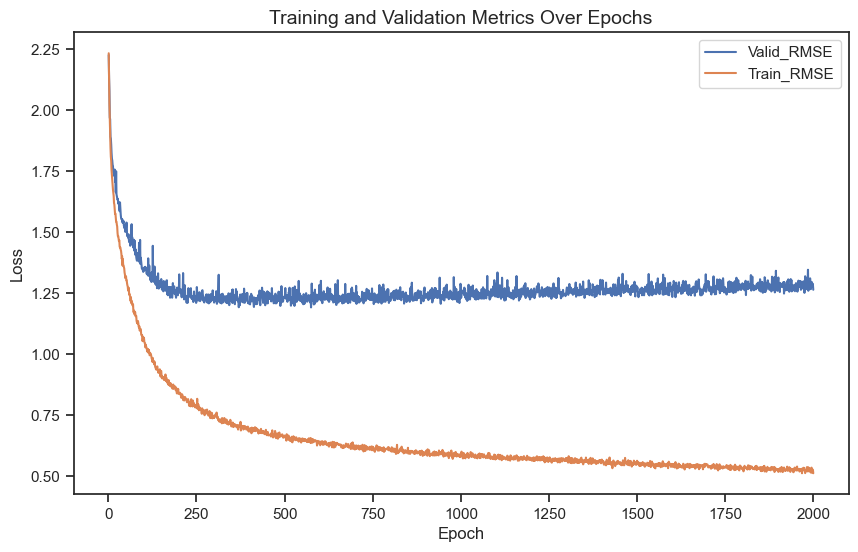

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [20]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.515938,0.514656,0.508607,0.508607,0.775433,0.880590,0.356924,NaN,1.294266,0.796548,0.796548,0.450000,0.685109,0.562877,0.454951,0.775437,1.292690
1996,1997,0.531152,0.524407,0.509303,0.509303,0.771178,0.878174,0.356428,NaN,1.275135,0.775339,0.775339,0.458130,0.689168,0.517742,0.458308,0.771190,1.273521
1997,1998,0.523882,0.524318,0.510871,0.510871,0.771217,0.878190,0.357281,NaN,1.289032,0.784035,0.784035,0.452225,0.685777,0.529418,0.452516,0.771217,1.287316
1998,1999,0.532872,0.526476,0.507461,0.507461,0.770275,0.877655,0.351162,NaN,1.283133,0.783863,0.783863,0.454731,0.686196,0.526254,0.455784,0.770278,1.281515
1999,2000,0.510731,0.511857,0.503622,0.503622,0.776654,0.881283,0.348260,NaN,1.263499,0.768750,0.768750,0.463075,0.690818,0.520474,0.463391,0.776655,1.261750


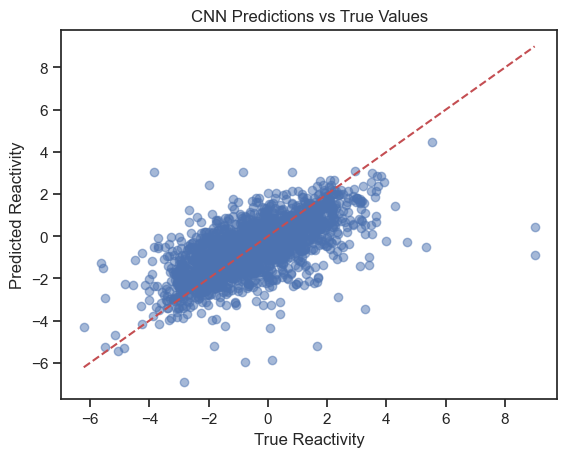

In [21]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()


In [13]:
# 載入模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
save_dir = r'.\pinchi_code\original dataset\trained_model\cold_protein'

# 需要知道訓練時的特徵維度
mol_input_dim = data.loc[0,'metabolite_features'].shape[0]  # 請替換成你的實際維度
protein_input_dim = data.loc[0,"protein_features"].shape[0]  # 請替換成你的實際維度

# 初始化模型並載入權重
model = CNNRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model.load_state_dict(torch.load(r"..\..\trained_model\cold_protein\CNN model_cold_protein.pt", map_location=device))
model = model.to(device)
model.eval()  # 設定為評估模式

# 進行預測
def predict(model, mol_features, protein_features):
    """
    mol_features: numpy array or tensor, shape (batch_size, mol_input_dim)
    protein_features: numpy array or tensor, shape (batch_size, protein_input_dim)
    """
    with torch.no_grad():
        if isinstance(mol_features, np.ndarray):
            mol_features = torch.tensor(mol_features, dtype=torch.float32)
        if isinstance(protein_features, np.ndarray):
            protein_features = torch.tensor(protein_features, dtype=torch.float32)
        
        mol_features = mol_features.to(device)
        protein_features = protein_features.to(device)
        
        predictions = model(mol_features, protein_features)
        return predictions.cpu().numpy()

# 使用範例
mol_features = np.stack(data["metabolite_features"])
protein_features = np.stack(data["protein_features"])
predictions = predict(model, mol_features, protein_features)
print(f"Predicted Kd: {predictions}")


Using device: cuda
Predicted Kd: [-0.61922693 -0.75844526 -0.9747951  ... -0.70772016 -0.8542999
 -0.85294247]


In [14]:
data_cold_protein = data.copy()
data_cold_mols = data.copy()
import os
prefix="CNN"
'''
if os.path.exists('data_cold_protein.joblib'):
    data_cold_protein = joblib.load('data_cold_protein.joblib')
    if prefix+"_pred" in data_cold_protein.columns:
        raise ValueError("data_cold_protein already has a prediction column.")
    else:
        data_cold_protein[prefix+"_pred"] = predictions
else:
    data_cold_protein[prefix+"_pred"] = predictions
joblib.dump(data_cold_protein, 'data_cold_protein.joblib')'''

if os.path.exists('data_cold_mols.joblib'):
    data_cold_mols = joblib.load('data_cold_mols.joblib')
    if prefix+"_pred" in data_cold_mols.columns:
        raise ValueError("data_cold_mols already has a prediction column.")
    else:
        data_cold_mols[prefix+"_pred"] = predictions
else:
    data_cold_mols[prefix+"_pred"] = predictions
joblib.dump(data_cold_mols, 'data_cold_mols.joblib')

['data_cold_mols.joblib']